# BIOSPACE25 Workshop: 

## Harnessing analysis tools for biodiversity applications using field, airborne, and orbital remote sensing data from NASA's BioSCAPE campaign

Michele Thornton, Rupesh Shrestha, Erin Hestir, Adam Wilson, Jasper Slingsby, Anabelle Cardoso

**Date:**  February 12, 2025, Frascati (Rome), Italy

![BIOSPACE25](../avirisng/images/BioSpace25_clip_50.jpg)

# Exploring and Visualizing BioSCape LVIS Data

## Overview
[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This tutorial will demonstrate accessing and visualizing **Land, Vegetation, and Ice Sensor (LVIS)** data available on the BioSCape SMCE. LVIS is an airborne, wide-swath imaging full-waveform laser altimeter. LVIS collects in a 1064 nm-wavelength (near infrared) range with 3 detectors mounted in an airborne platform, flown typically ~10 km above the ground producing a data swath of 2km wide with 7-10 m footprints. More information about the LVIS instrument is [here](https://lvis.gsfc.nasa.gov/Home/instrumentdetails.html).

The LVIS instrument has been flown above several regions of the world since 1998. The LVIS flights were collected for the [BioSCAPE campaigns](https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html) from `01 Oct 2023` through `30 Nov 2023`.

There are three LVIS BioSCape data products currently available and archived at [NSIDC DAAC](https://search.earthdata.nasa.gov/search?q=LVIS&qt=2023-10-20T00%3A00%3A00.000Z%2C2023-11-15T23%3A59%3A59.999Z&fi=LVIS-Camera!LVIS&fdc=National%2BSnow%2Band%2BIce%2BData%2BCenter%2BDistributed%2BActive%2BArchive%2BCenter%2B%2528NSIDC%2BDAAC%2529&fpj=BioSCape&_ga=2.63606251.53278573.1721067437-1362124365.1714395655&_gl=1*q0ghrk*_ga*MTM2MjEyNDM2NS4xNzE0Mzk1NjU1*_ga_LQ2P0SNJCZ*MTcyMTU5NTQ4Ni4xMjMuMS4xNzIxNTk1NjkxLjAuMC4w)

| Dataset | Dataset DOI | 
| -------- | --- |
| LVIS L1A Geotagged Images V001 | [10.5067/NE5KKKBAQG44](https://doi.org/10.5067/NE5KKKBAQG44) |
| LVIS Facility L1B Geolocated Return Energy Waveforms V001 | [10.5067/XQJ8PN8FTIDG](https://doi.org/10.5067/XQJ8PN8FTIDG) |
| LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001 | [10.5067/VP7J20HJQISD](https://doi.org/10.5067/VP7J20HJQISD) |

For this tutorial, we'll examine the `LVIS L2 Geolocated Surface Elevation and Canopy Height Product V001`

- **Citation:** Blair, J. B. & Hofton, M. (2020). LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product, Version 1 [Data Set]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/VP7J20HJQISD.
- **User Guide** [LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product, Version ](https://nsidc.org/sites/default/files/lvisf2-v001-userguide_2_0.pdf)1

![LVIS Waveform](assets/lvis_waveform.png)
**Figure:** Sample LVIS product waveforms illustrating possible distributions of reflected light (Blair et al., 2020)


In [1]:
from glob import glob
import numpy as np
import pandas as pd
import earthaccess
import geopandas as gpd
import requests as re
import s3fs
import h5py
from os import path
from datetime import datetime
from shapely.ops import orient
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from shapely.geometry import box
import dask.dataframe as dd
from harmony import BBox,Client, Collection, Request, LinkType

In [2]:
# esri background basemap for maps
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"

## Authentication
We recommend authenticating your Earthdata Login (EDL) information using the `earthaccess` python library as follows:

In [3]:
# works if the EDL login already been persisted to a netrc
try:
    auth = earthaccess.login(strategy="netrc")
except FileNotFoundError:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## Structure LVIS L1B Geolocated Waveform

First, let's find out how many L1B files from the BioSCape Campaign are published on NASA Earthdata.

In [4]:
doi="10.5067/XQJ8PN8FTIDG" # LVIS L1B doi
query = earthaccess.DataGranules().doi(doi)
query.params['campaign'] = 'bioscape'
l1b = query.get_all()
print(f'Granules found: {len(l1b)}')

Granules found: 2328


There are 2328 granules LVIS L1B product found for the time period. Let's see if they are hosted on Earthdata cloud or not, by printing a summary of the first granule

In [5]:
l1b[0]

Collection: {'EntryTitle': 'LVIS Facility L1B Geolocated Return Energy Waveforms V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 19.33306, 'Latitude': -32.96535}, {'Longitude': 19.32879, 'Latitude': -32.96894}, {'Longitude': 19.2562, 'Latitude': -33.02274}, {'Longitude': 19.17507, 'Latitude': -33.08012}, {'Longitude': 19.09821, 'Latitude': -33.13751}, {'Longitude': 19.10248, 'Latitude': -33.15903}, {'Longitude': 19.14518, 'Latitude': -33.13751}, {'Longitude': 19.21777, 'Latitude': -33.08012}, {'Longitude': 19.29036, 'Latitude': -33.03349}, {'Longitude': 19.36722, 'Latitude': -32.97612}, {'Longitude': 19.36295, 'Latitude': -32.96175}, {'Longitude': 19.33733, 'Latitude': -32.96175}, {'Longitude': 19.33306, 'Latitude': -32.96535}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-20T07:36:13.511Z', 'EndingDateTime': '2023-10-20T07:38:46.605Z'}}
Size(MB): 921.264
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF1B.001/2023.10.20/LVISF1B_BioSCape2023_1020_R2404_027373.h5']

As we see above, the LVIS files are not cloud-hosted yet. They have to be downloaded locally and use them. We will go ahead and use earthaccess python module to get the file directly and save it to the `downloads` directory.

In [6]:
# download files
downloaded_files = earthaccess.download(l1b[0], local_path="downloads")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Now, we go ahead and open a file to look at its structure.

In [7]:
l1b_first = f'downloads/{path.basename(l1b[0].data_links()[0])}'
with h5py.File(l1b_first) as hf:
    for v in list(hf.keys()):
        if v != "ancillary_data":
            print(f"- {v} : {hf[v].attrs['description'][0].decode('utf-8')}")

- AZIMUTH : Azimuth angle of laser beam
- INCIDENTANGLE : Off-nadir incident angle of laser beam
- LAT0 : Latitude of the highest sample of the return waveform (degrees north) 
- LAT1215 : Latitude of the lowest sample of the return waveform (degrees north) 
- LFID : LVIS file identification.  Together with 'LVIS shotnumber' these are a unique identifier for every LVIS laser shot. Format is XXYYYYYZZZ where XX identifies instrument version, YYYYY is the Modified Julian Date of the flight departure day, ZZZ represents file number.
- LON0 : Longitude of the highest sample of the return waveform (degrees east)
- LON1215 : Longitude of the lowest sample of the return waveform (degrees east) 
- RANGE : Distance along laser path from the instrument to the ground
- RXWAVE : Returned waveform (1216 samples long)
- SHOTNUMBER : Laser shot number assigned during collection.  Together with 'LVIS LFID' provides a unique identifier to every LVIS laser shot.
- SIGMEAN : Signal mean noise level, calc

In [8]:
with h5py.File(l1b_first) as hf:
    l_lat = hf['LAT1215'][:]
    l_lon = hf['LON1215'][:]
    l_range = hf['Z1215'][:] # ground elevation
    shot = hf['SHOTNUMBER'][:] # ground elevation
geo_arr = list(zip(shot, l_range,l_lat,l_lon))
l1b_df = pd.DataFrame(geo_arr, columns=["shot_number", "elevation", "lat", "lon"])
l1b_df

shot_number    elevation        lat        lon
0           1273584  1029.488037 -33.148042  19.102309
1           1273585  1031.285889 -33.147988  19.102368
2           1273586  1029.556763 -33.147992  19.102242
3           1273587  1031.303711 -33.147938  19.102302
4           1273588  1030.956665 -33.147943  19.102177
...             ...          ...        ...        ...
349995      1885946  1043.302979 -32.967379  19.360638
349996      1885947  1043.851929 -32.967325  19.360697
349997      1885948  1042.134399 -32.967430  19.360705
349998      1885949  1044.154175 -32.967375  19.360763
349999      1885950  1041.007568 -32.967480  19.360771

[350000 rows x 4 columns]

In [9]:
l1b_gdf = gpd.GeoDataFrame(l1b_df, crs="EPSG:4326",
                           geometry=gpd.points_from_xy(l1b_df.lon, 
                                                       l1b_df.lat))
l1b_gdf.sample(frac=0.01).explore("elevation", cmap = "plasma", tiles=xyz, attr=attr)

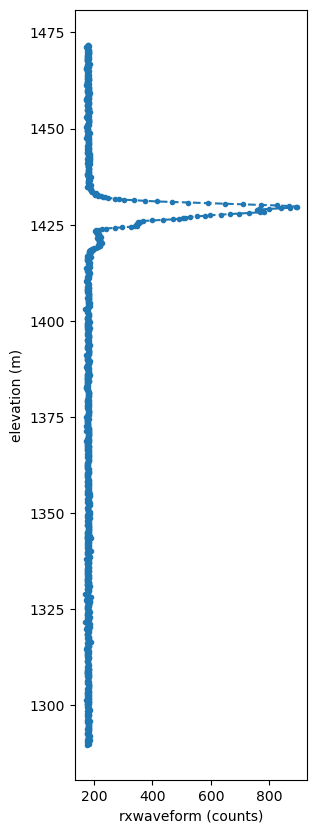

In [10]:
i = np.where(shot==1319816)[0][0]
with h5py.File(l1b_first) as hf:
    rxwaveform = hf['RXWAVE'][i, :] # waveform
    elev_1215 = hf['Z1215'][i] # elevation ground
    elev_0 = hf['Z0'][i] # elevation top
c = len(rxwaveform) #
elev = np.linspace(elev_1215, elev_0, num=c)
# plot
plt.rcParams["figure.figsize"] = (3,10)
plt.xlabel("rxwaveform (counts)")
plt.ylabel("elevation (m)")
plt.plot(rxwaveform, elev, linestyle='--', marker='.',)
plt.show()

## Structure of LVIS L2 Canopy Height Product
First, let's search how many L2 files are there for the BioSCape campaign dates.

In [11]:
doi="10.5067/VP7J20HJQISD" # LVIS L2 doi
query = earthaccess.DataGranules().doi(doi)
query.params['campaign'] = 'bioscape'
l2 = query.get_all()
print(f'Granules found: {len(l2)}')

Granules found: 2328


There are 2328 granules LVIS L2 product found for the time period. Let's see if they are hosted on Earthdata cloud or not, by printing a summary of the first granule

In [12]:
l2[0]

Collection: {'EntryTitle': 'LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 19.33306, 'Latitude': -32.96526}, {'Longitude': 19.32879, 'Latitude': -32.96885}, {'Longitude': 19.2562, 'Latitude': -33.02265}, {'Longitude': 19.17507, 'Latitude': -33.08003}, {'Longitude': 19.09821, 'Latitude': -33.13742}, {'Longitude': 19.10248, 'Latitude': -33.15894}, {'Longitude': 19.15372, 'Latitude': -33.13383}, {'Longitude': 19.22631, 'Latitude': -33.07645}, {'Longitude': 19.30317, 'Latitude': -33.02265}, {'Longitude': 19.36722, 'Latitude': -32.97603}, {'Longitude': 19.36295, 'Latitude': -32.96166}, {'Longitude': 19.33733, 'Latitude': -32.96166}, {'Longitude': 19.33306, 'Latitude': -32.96526}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-20T07:36:13.511Z', 'EndingDateTime': '2023-10-20T07:38:46.605Z'}}
Size(MB): 128.175
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF2.001/2023.10.20/LVISF2_BioSCape2023_1020_R2404_027373.TXT']

As we see above, the LVIS files are not cloud-hosted yet. They have to be downloaded locally and use them. We will go ahead and use earthaccess python module to get the file directly and save it to the `downloads` directory.

In [13]:
# download files
downloaded_files = earthaccess.download(l2[0], local_path="downloads")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Now, we'll go ahead and open a file to look at it's structure.

In [14]:
l2_first = f'downloads/{path.basename(l2[0].data_links()[0])}'
with open(l2_first, 'rb') as f:
    head = [next(f) for _ in range(15)]
    print(head)

[b"# Level2 (v2.0.5) data set collected by NASA's Land, Vegetation and Ice Sensor (LVIS) Facility in October-November 2023 as part of NASA's BioSCape Field Campaign. This file contains elevation,\n", b"# height and surface structure metrics derived from LVIS's geolocated laser return waveform. The corresponding spatially geolocated laser return waveforms are contained in the Level 1B data set.\n", b'# For supporting information please visit https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html. LVIS-targeted data collections occurred at flight altitudes of ~7 km above the surface from\n', b'# the NASA G-V, however data collections also occurred at lower altitudes. The "Range" parameter can be used to determine flight altitude. Note: Two alternate ground elevations options are provided\n', b'# in order to provide flexibility for local site conditions; if selected for use, adjust the values of the RH parameters accordingly. Please consult the User Guide for further information. Th

LVIS L2A files have a number of lines as header as shown above. Let's define a python function to read the number of header rows.

In [15]:
def get_line_number(filename):
    """find number of header rows in LVIS L2A"""
    count = 0
    with open(filename, 'rb') as f:
        for line in f:
            if line.startswith(b'#'):
                count = count + 1
                columns = line[1:].split()
            else:
                return count, columns

In [16]:
h_no, col_names = get_line_number(l2_first)
with open(l2_first, 'rb') as f:
    l2a_df = pd.read_csv(f, skiprows=h_no, header=None, engine='python', sep=r'\s+')
    l2a_df.columns =  [x.decode() for x in col_names]
l2a_df

LFID  SHOTNUMBER         TIME       GLON       GLAT       ZG  \
0       1960237015     1273584  27373.51196  19.102319 -33.148059  1071.25   
1       1960237015     1273585  27373.51221  19.102377 -33.148005  1072.48   
2       1960237015     1273586  27373.51246  19.102253 -33.148010  1071.28   
3       1960237015     1273587  27373.51271  19.102312 -33.147956  1072.80   
4       1960237015     1273588  27373.51296  19.102187 -33.147961  1071.89   
...            ...         ...          ...        ...        ...      ...   
349995  1960237020     1885946  27526.60418  19.360614 -32.967373  1085.76   
349996  1960237020     1885947  27526.60443  19.360673 -32.967319  1085.67   
349997  1960237020     1885948  27526.60468  19.360680 -32.967423  1084.36   
349998  1960237020     1885949  27526.60493  19.360739 -32.967369  1085.64   
349999  1960237020     1885950  27526.60518  19.360747 -32.967473  1082.79   

        ZG_ALT1  ZG_ALT2       HLON       HLAT  ...  RH99  RH100  AZIMUTH  \
0       1071.25  1071.25  19.102319 -33.148059  ...  1.27   2.02   334.64   
1       1072.48  1072.48  19.102377 -33.148005  ...  1.35   2.21   335.79   
2       1071.28  1071.28  19.102253 -33.148010  ...  1.27   2.06   334.14   
3       1072.80  1072.80  19.102312 -33.147956  ...  1.16   1.83   335.27   
4       1071.89  1071.89  19.102187 -33.147961  ...  1.42   2.24   333.67   
...         ...      ...        ...        ...  ...   ...    ...      ...   
349995  1085.76  1085.76  19.360614 -32.967373  ...  3.25   4.30   107.38   
349996  1085.67  1085.67  19.360673 -32.967319  ...  3.22   4.41   106.36   
349997  1084.36  1084.36  19.360680 -32.967423  ...  2.77   4.15   107.87   
349998  1085.64  1085.64  19.360739 -32.967369  ...  2.95   3.89   106.86   
349999  1082.79  1082.79  19.360747 -32.967473  ...  2.84   4.34   108.34   

        INCIDENTANGLE    RANGE  COMPLEXITY  SENSITIVITY  CHANNEL_ZT  \
0               2.885  7368.90       0.099        0.988           1   
1               2.910  7368.00       0.063        0.987           1   
2               2.944  7369.80       0.088        0.985           1   
3               2.968  7367.70       0.078        0.987           1   
4               3.003  7369.35       0.121        0.988           1   
...               ...      ...         ...          ...         ...   
349995          3.167  7364.93       0.201        0.992           1   
349996          3.195  7364.48       0.239        0.992           1   
349997          3.225  7366.28       0.142        0.990           1   
349998          3.252  7365.83       0.195        0.990           1   
349999          3.283  7367.33       0.109        0.991           1   

        CHANNEL_ZG  CHANNEL_RH  
0                1           1  
1                1           1  
2                1           1  
3                1           1  
4                1           1  
...            ...         ...  
349995           1           1  
349996           1           1  
349997           1           1  
349998           1           1  
349999           1           1  

[350000 rows x 45 columns]

Let's print LVIS L2 variable names.

In [17]:
l2a_df.columns.values

array(['LFID', 'SHOTNUMBER', 'TIME', 'GLON', 'GLAT', 'ZG', 'ZG_ALT1',
       'ZG_ALT2', 'HLON', 'HLAT', 'ZH', 'TLON', 'TLAT', 'ZT', 'RH10',
       'RH15', 'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50',
       'RH55', 'RH60', 'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90',
       'RH95', 'RH96', 'RH97', 'RH98', 'RH99', 'RH100', 'AZIMUTH',
       'INCIDENTANGLE', 'RANGE', 'COMPLEXITY', 'SENSITIVITY',
       'CHANNEL_ZT', 'CHANNEL_ZG', 'CHANNEL_RH'], dtype=object)

Key variables:
- The `GLAT` and `GLON` variables provide coordinates of the lowest detected mode within the LVIS waveform.
- The `RHXX` variables provide height above the lowest detected mode at which XX percentile of the waveform energy.
- `RANGE` provides the distance from the instrument to the ground.
- `SENSITIVITY` provides sensitivity metric for the return waveform.
- `ZG`,`ZG_ALT1`, `ZG_ALT2`: Mean elevation of the lowest detected mode using alternate 1/2 mode detection settings. The alternative `ZG` to use to adjust the RH parameters for local site conditions.

More information about the variables are provided in the [user guide](https://nsidc.org/sites/default/files/lvisf2-v001-userguide_2_0.pdf).

Let's select the particular shot we are interested in.

In [18]:
l2a_shot_df = l2a_df[l2a_df['SHOTNUMBER'] == 1319816]
l2a_shot_df

LFID  SHOTNUMBER         TIME       GLON       GLAT       ZG  \
36489  1960237015     1319816  27385.07009  19.123985 -33.135646  1331.96   

       ZG_ALT1  ZG_ALT2       HLON       HLAT  ...  RH99  RH100  AZIMUTH  \
36489  1331.96  1331.96  19.123984 -33.135648  ...  10.0  11.31    27.63   

       INCIDENTANGLE    RANGE  COMPLEXITY  SENSITIVITY  CHANNEL_ZT  \
36489          1.317  7102.77       0.387         0.99           1   

       CHANNEL_ZG  CHANNEL_RH  
36489           1           1  

[1 rows x 45 columns]

Now, we can plot the RH metrics with elevation.

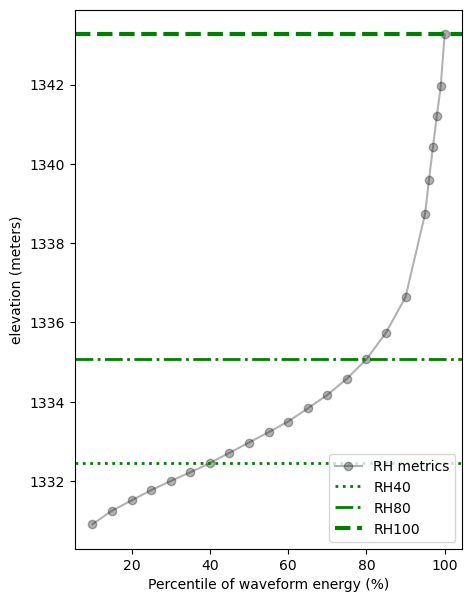

In [19]:
elev_zg = l2a_shot_df.ZG.values[0]
elev_zh = l2a_shot_df.ZH.values[0]
rh40 = l2a_shot_df.RH40.values[0]
rh80 = l2a_shot_df.RH80.values[0]
rh100 = l2a_shot_df.RH100.values[0]
rh = l2a_shot_df.filter(like ='RH').drop('CHANNEL_RH', axis=1).values.tolist()[0]

# plotting
plt.rcParams["figure.figsize"] = (5,7)
rh_vals = l2a_shot_df.filter(like = 'RH').columns[:-1].str.strip('RH').astype(int).tolist()
fig, ax1 = plt.subplots()
ax1.plot(rh_vals, elev_zg+rh, alpha=0.3, marker='o', color='black', label='RH metrics' )
ax1.axhline(y=elev_zg+rh40,  color='g', linestyle='dotted', linewidth=2, label='RH40')
ax1.axhline(y=elev_zg+rh80,  color='g', linestyle='-.', linewidth=2, label='RH80')
ax1.axhline(y=elev_zg+rh100,  color='g', linestyle='--', linewidth=3, label='RH100')
ax1.set_xlabel("Percentile of waveform energy (%)")
ax1.set_ylabel("elevation (meters)")
ax1.legend(loc="lower right")
plt.show()

## Plot LVIS Bioscape Campaigns
Lets first define two functions that we can use to plot the search results above over a basemap. 

In [20]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

Now, we will convert the JSON return from the `earthaccess` granule search into a geopandas dataframe so we could plot over an ESRI basemap. 

In [21]:
gdf = convert_list_gdf(l2)
#plot
gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr)

The above shows the flight lines of all LVIS collection during the BioSCape campaign in 2023.

### Search LVIS L2A granules over a study area
The study area is [Brackenburn Private Nature Reserve](https://plcnetwork.co.za/member/121/Brackenburn-Private-Nature-Reserve/). 

In [22]:
poly_f = "assets/brackenburn.json"
poly = gpd.read_file(poly_f)
poly.explore(tiles=xyz, attr=attr, style_kwds={'color':'red', 'fill':False})

Let's search for LVIS L2A granules that are within the bounds of the study area.

In [23]:
poly.geometry = poly.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .005 degrees
xy = poly.geometry.simplify(0.005).get_coordinates()

granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi="10.5067/VP7J20HJQISD", # LVIS L2A doi
    temporal=("2023-10-01", "2023-11-30"), # Bioscape campaign dates
    polygon=list(zip(xy.x, xy.y))
)
print(f'Granules found: {len(granules)}')

Granules found: 9


Let's plot these flight lines over a basemap.

In [24]:
m = gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr, 
                                              style_kwds={'fillOpacity':0.1})
m

### Download L2 granules
In the above section, we retrieved the overlapping granules using the `earthaccess` module, which we will also use to download the files.

In [25]:
downloaded_files = earthaccess.download(granules, local_path="downloads")

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

Earthaccess download uses a parallel downloading feature so all the files are downloaded efficiently. It also avoids duplicated downloads if a file has already been downloaded previously to the local path.

### Read LVIS L2A Files

Now, we can read the LVIS L2A files into a pandas dataframe.

In [26]:
# get header rows and column names
h_no, col_names = get_line_number(downloaded_files[0])
# read the LVIS L2A files
ddf = dd.read_csv(downloaded_files, skiprows=h_no, 
                           names=[x.decode() for x in col_names],
                           header=None, sep=r'\s+') 
# dask to pandas dataframe
df = ddf.compute()
# converting to geopandas
lvis_l2a_gdf = gpd.GeoDataFrame(df, 
                                geometry=gpd.points_from_xy(df.GLON, 
                                                            df.GLAT),
                                crs="EPSG:4326")
# clipping LVIS by polygon
lvis_l2a_gdf = gpd.sjoin(lvis_l2a_gdf, poly, predicate='within')

### Height of Top Canopy
Let's plot RH100 (height of top canopy) values in a map.

In [27]:
lvis_l2a_gdf[['RH100', 'geometry']].sample(frac=0.1, random_state=1).explore(
    "RH100", cmap = "YlGn", tiles=xyz, attr=attr, alpha=0.5, radius=10, legend=True)

### Relative Height Distribution
We can generate a plot of RH metrics to check if the vegetation height across the percentile of waveform energy indicates the same. 

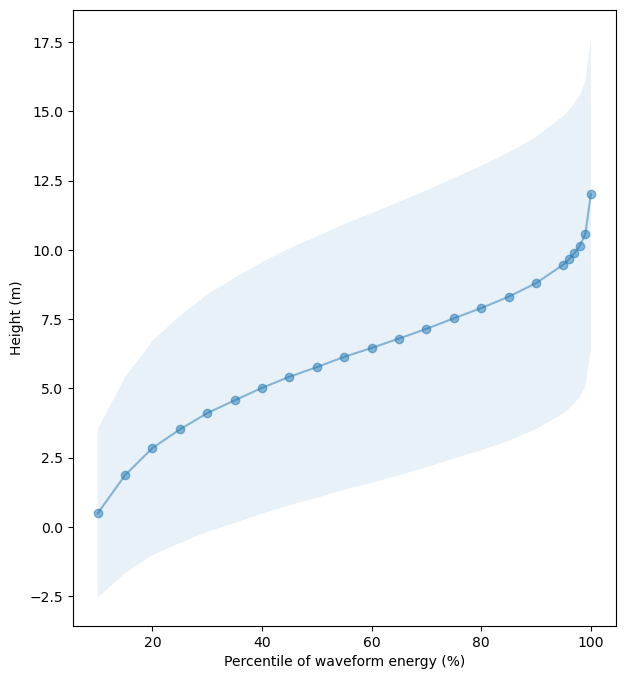

In [28]:
fig, ax = plt.subplots(figsize=(7, 8))
plot_df = lvis_l2a_gdf.sample(frac=0.1, random_state=1).filter(like='RH').drop('CHANNEL_RH', axis=1).T
plot_df.index = plot_df.index.str.strip('RH').astype(int)
std_df = plot_df.std(axis=1)
median_df = plot_df.median(axis=1)
median_df.plot(ax=ax, alpha=0.5, style='o-')
ax.fill_between(plot_df.index, median_df - std_df, median_df + std_df, alpha=0.1)
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

In [29]:
# exporting 
# lvis_l2a_gdf.geometry.to_file('lvis2.geojson', driver="GeoJSON")
# lvis_l2a_gdf.to_csv('lvis.csv')

## GEDI L2A Canopy Height Metrics
This section of the tutorial will demonstrate how to directly access and subset the GEDI L2A canopy height metrics using [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov) and compute a summary of aboveground biomass density for a forest reserve. The Harmony API allows seamless access and production of analysis-ready Earth observation data across different DAACs by enabling cloud-based spatial, temporal, and variable subsetting and data conversions. The GEDI datasets are available from the [Harmony Trajectory Subsetter API](https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV.html)(id =`S2836723123-XYZ_PROV`).

We will use NASA’s Harmony Services to retrieve the GEDI L2A dataset and canopy heights (`RH100`) for the burned and unburned plots . The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.

### Dataset
The GEDI Level 2A Geolocated Elevation and Height Metrics product [GEDI02_A](https://doi.org/10.5067/GEDI/GEDI02_A.002) provides waveform interpretation and extracted products from eachreceived waveform, including ground elevation, canopy top height, and relative height (RH) metrics. GEDI datasets are available for the period starting 2019-04-17 and covers 52 N to 52 S latitudes. GEDI L2A data files are natively in HDF5 format.

### Authentication
NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the `earthaccess` Python library to set up authentication. Alternatively, you can also login to `harmony_client` directly by passing EDL authentication as the following in the Jupyter Notebook itself:
```
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

### Create Harmony Client Object
First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with the auth parameter.

In [30]:
harmony_client = Client()

In [31]:
concept_l2a = earthaccess.search_datasets(doi ='10.5067/GEDI/GEDI02_A.002')[0].concept_id()
concept_l2a

'C1908348134-LPDAAC_ECS'

### Retrieve Concept ID
Now, let’s retrieve the `Concept ID` of the GEDI L2A dataset. The `Concept ID` is NASA Earthdata’s unique ID for its dataset.

In [32]:
def get_concept_id(doi):
    """get concept id from DOI using earthaccess"""
    col = earthaccess.search_datasets(doi=doi)
    for ds in col:
        # check if Harmony trajectory subsets exists
        if 'S2836723123-XYZ_PROV' in ds.services().keys():
            return(ds.concept_id())

concept_l2a = get_concept_id('10.5067/GEDI/GEDI02_A.002') 
concept_l2a

'C2142771958-LPCLOUD'

### Define Request Parameters
Let’s create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L2A RH variables and temporal range.

In [33]:
# harmony collection
collection_l2a = Collection(id=concept_l2a)

def create_var_names(variables):
    # gedi beams
    beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
    # combine variables and beam names
    return [f'/{b}/{v}' for b in beams for v in variables]

# gedi variables
variables_l2a = create_var_names(['rh', 'quality_flag', 'land_cover_data/pft_class'])

# time range
temporal_range = {'start': datetime(2019, 4, 17), 
                  'stop': datetime(2023, 3, 31)}

### Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded.

In [34]:
def submit_harmony(collection, variables):
    """submit harmony request"""
    request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  shape=poly_f,
                  ignore_errors=True)
    # submit harmony request, will return job id
    subset_job_id = harmony_client.submit(request)
    return harmony_client.result_urls(subset_job_id, show_progress=True, 
                                      link_type=LinkType.s3)

results = submit_harmony(collection_l2a, variables_l2a)

A temporary S3 Credentials is needed for read-only, same-region (**us-west-2**), direct access to S3 objects on the Earthdata cloud. We will use the credentials from the `harmony_client`.

In [35]:
s3credentials = harmony_client.aws_credentials()

We will pass S3 credentials to [S3Fs](https://s3fs.readthedocs.io/) class S3FileSystem.

In [36]:
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=s3credentials['aws_access_key_id'], 
                          secret=s3credentials['aws_secret_access_key'], 
                          token=s3credentials['aws_session_token'])

### Read Subset files
First, we will define a python function to read the GEDI variables, which are organized in a hierarchical way.

In [37]:
def read_gedi_vars(beam):
    """reads through gedi variable hierarchy"""
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        # check if the item is a group
        if isinstance(value, h5py.Group):
            # looping through subgroups
            for key2, value2 in value.items():
                col_names.append(key2)
                col_val.append(value2[:].tolist())
        else:
            col_names.append(key)
            col_val.append(value[:].tolist())
    return col_names, col_val

Let’s direct access the subsetted h5 files and retrieve its values into the pandas dataframe.

In [38]:
# define an empty pandas dataframe
subset_df = pd.DataFrame()
# loop through the Harmony results
for s3_url in results:
    print(s3_url)
    with fs_s3.open(s3_url, mode='rb') as fh:
        with h5py.File(fh) as l2a_in:
            for v in list(l2a_in.keys()):
                if v.startswith('BEAM'):
                    c_n, c_v = read_gedi_vars(l2a_in[v])
                    # Appending to the subset_df dataframe
                    subset_df = pd.concat([subset_df, 
                                           pd.DataFrame(map(list, zip(*c_v)), 
                                                        columns=c_n)])

 [ Processing:  80% ] |########################################           | [/]
Job is running with errors.
 [ Processing: 100% ] |###################################################| [|]


s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643680/GEDI02_A_2019295150627_O04871_04_T01992_02_003_01_V002_subsetted.h5
s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643681/GEDI02_A_2020029234554_O06412_04_T04838_02_003_01_V002_subsetted.h5
s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643683/GEDI02_A_2020249085848_O09813_04_T10530_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643692/GEDI02_A_2022303102350_O21984_04_T08954_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643685/GEDI02_A_2021076044301_O12802_04_T10530_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643679/GEDI02_A_2019187095905_O03192_04_T04838_02_003_01_V002_subsetted.h5
s3://harmony-prod-staging/public/8ba6d5e4-3c6b-416e-b060-cd07d928a52d/89643695/GEDI02_A_2023043015154_O23607_01_T02319

Let's remove the duplicate columns, if any, and print the first two rows of the pandas dataframe.

In [39]:
# remove duplicate columns
subset_df = subset_df.loc[:,~subset_df.columns.duplicated()].copy()
subset_df.head(2)

delta_time  lat_lowestmode_a1  lon_lowestmode_a1  pft_class  \
0  5.699684e+07         -33.980677          23.474329          2   
1  5.699684e+07         -33.981021          23.474758          2   

   lat_lowestmode  lon_lowestmode  quality_flag  \
0      -33.980689       23.474348             0   
1      -33.981041       23.474788             0   

                                                  rh  
0  [-0.5600000023841858, -0.5199999809265137, -0....  
1  [-1.190000057220459, -1.0800000429153442, -0.9...

### RH metrics
Let's first split the `rh` variables into different columns. There are a total of 101 steps of percentiles defined starting from 0 to 100%.

In [40]:
# create rh metrics column
rh = []
# loop through each percentile and create a RH column
for i in range(101):
    y = pd.DataFrame({f'RH{i}':subset_df['rh'].apply(lambda x: x[i])})
    rh.append(y)
rh = pd.concat(rh, axis=1)

# concatenate RH columns to the original dataframe
subset_df = pd.concat([subset_df, rh], axis=1)
# print the first row of dataframe
subset_df.head(2)

delta_time  lat_lowestmode_a1  lon_lowestmode_a1  pft_class  \
0  5.699684e+07         -33.980677          23.474329          2   
1  5.699684e+07         -33.981021          23.474758          2   

   lat_lowestmode  lon_lowestmode  quality_flag  \
0      -33.980689       23.474348             0   
1      -33.981041       23.474788             0   

                                                  rh   RH0   RH1  ...  RH91  \
0  [-0.5600000023841858, -0.5199999809265137, -0.... -0.56 -0.52  ...  4.37   
1  [-1.190000057220459, -1.0800000429153442, -0.9... -1.19 -1.08  ...  5.79   

   RH92  RH93  RH94  RH95  RH96  RH97  RH98  RH99  RH100  
0  4.41  4.44  4.48  4.52  4.59  4.63  4.67  4.71   4.78  
1  5.86  5.94  6.05  6.13  6.20  6.31  6.39  6.50   6.61  

[2 rows x 109 columns]

In [41]:
gedi_gdf = gpd.GeoDataFrame(subset_df, 
                            geometry=gpd.points_from_xy(subset_df.lon_lowestmode, 
                                                        subset_df.lat_lowestmode),
                                crs="EPSG:4326")
gedi_sub = gpd.sjoin(gedi_gdf, poly, predicate='within')
gedi_sub[gedi_sub.quality_flag==1].explore("RH100", cmap = "YlGn", tiles=xyz, attr=attr, alpha=0.5, radius=10, legend=True)

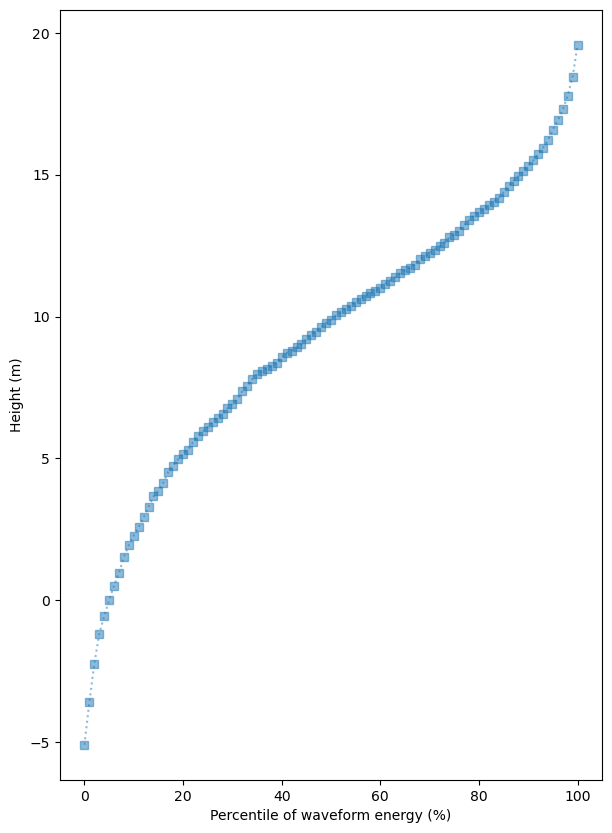

In [42]:
fig, ax = plt.subplots(figsize=(7, 10))
plot_df = gedi_sub[gedi_sub.quality_flag==1].filter(like='RH').T
plot_df.index = plot_df.index.str.strip('RH').astype(int)
plot_df.median(axis=1).plot(ax=ax, alpha=0.5, style='s:')
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

## GEDI Waveform Structural Complexity Index (WSCI)

GEDI WSCI product ([GEDI L4C](https://daac.ornl.gov/GEDI/guides/GEDI_L4C_WSCI.html)) provides inference on forest structural complexity, which affects ecosystem functions, nutrient cycling, biodiversity, and habitat quality ([Tiago et al. 2024](https://www.nature.com/articles/s41467-024-52468-2))

In [43]:
concept_l4c = get_concept_id('10.3334/ORNLDAAC/2338') # GEDI L4C DOI
# harmony collection
collection_l4c = Collection(id=concept_l4c)
# gedi variables
variables_l4c = create_var_names(['wsci', 'wsci_quality_flag'])
# define an empty pandas dataframe
subset_df2 = pd.DataFrame()
# submit harmony
results2 = submit_harmony(collection_l4c, variables_l4c)
# loop through the Harmony results
for s3_url in results2:
    print(s3_url)
    with fs_s3.open(s3_url, mode='rb') as fh:
        with h5py.File(fh) as l4c_in:
            for v in list(l4c_in.keys()):
                if v.startswith('BEAM'):
                    c_n, c_v = read_gedi_vars(l4c_in[v])
                    # Appending to the subset_df dataframe
                    subset_df2 = pd.concat([subset_df2, 
                                           pd.DataFrame(map(list, zip(*c_v)), 
                                                        columns=c_n)])

 [ Processing: 100% ] |###################################################| [|]


s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643714/GEDI04_C_2020249085848_O09813_04_T10530_02_001_01_V002_subsetted.h5
s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643712/GEDI04_C_2020029234554_O06412_04_T04838_02_001_01_V002_subsetted.h5
s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643711/GEDI04_C_2019295150627_O04871_04_T01992_02_001_01_V002_subsetted.h5
s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643710/GEDI04_C_2019187095905_O03192_04_T04838_02_001_01_V002_subsetted.h5
s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643713/GEDI04_C_2020096211823_O07449_04_T01992_02_001_01_V002_subsetted.h5
s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643723/GEDI04_C_2022303102350_O21984_04_T08954_02_001_01_V002_subsetted.h5
s3://harmony-prod-staging/public/c2922a2d-530f-4c75-93a8-f5fa4eee0056/89643717/GEDI04_C_2021172232047_O14302_01_T08011

Now, let's plot `wsci` variable for the good quality shots, which provides predicted 3D canopy entropy from the corresponding plant functional type or PFT (PFT=2 in this case).

In [44]:
# remove duplicate columns
subset_df2 = subset_df2.loc[:,~subset_df2.columns.duplicated()].copy()
gedi_gdf2 = gpd.GeoDataFrame(subset_df2, 
                                geometry=gpd.points_from_xy(subset_df2.lon_lowestmode, 
                                                            subset_df2.lat_lowestmode),
                                crs="EPSG:4326")
gedi_sub2 = gpd.sjoin(gedi_gdf2, poly, predicate='within')
gedi_sub2[gedi_sub2.wsci_quality_flag==1].explore("wsci", cmap = "YlGn", tiles=xyz, attr=attr, 
                                                  alpha=0.5, radius=10, legend=True)